<a href="https://colab.research.google.com/github/likchuan/LVAD_Lumped_modeling/blob/main/Circulationmodel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Circulatory model
The circulatory modeling framework described here is based on the closed loop model in [Shavik et al.](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6980470/)

A schematic of the closed loop model is shown below with the LV and RV described by a time varying elastance model
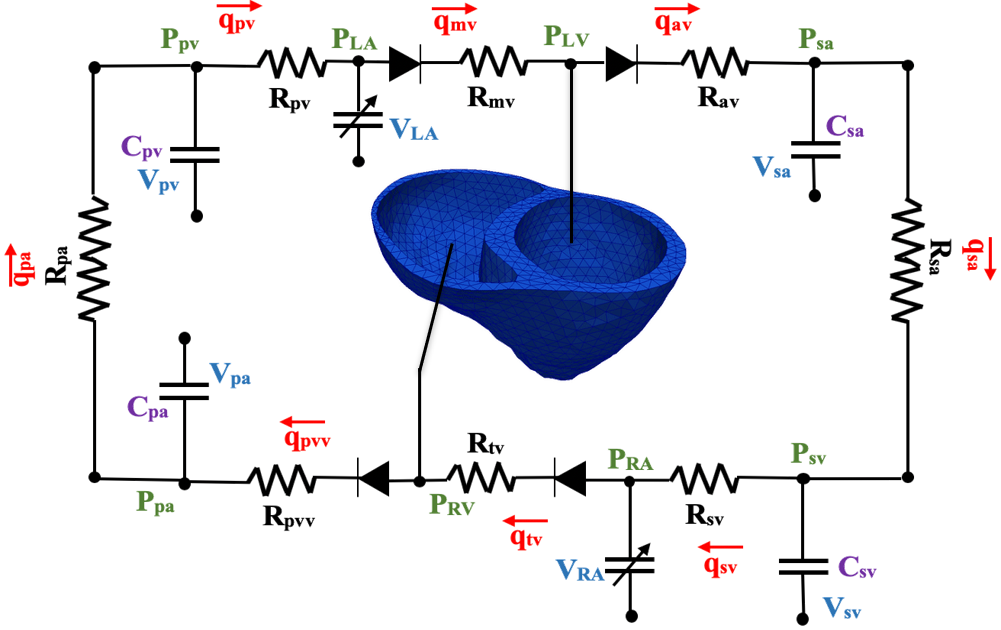

In [ ]:
#@title Parameters
# Parameters
import numpy as np
import math as math
import matplotlib.pyplot as plt

dt = 1;
cycle_time = 760.0;
ncycle = 25;
AV = 160; #AV delay


t = np.linspace(0, ncycle*cycle_time/dt, int(ncycle*cycle_time/dt)+1);
Vol = np.zeros((len(t),8));
Prs = np.zeros((len(t),8));
Q = np.zeros((len(t), 9));

VLV = 50;
Vsa = 650;  #initial value
Vsv = 3800;  #initial value
Vra = 12.5;  #initial value
VRV = 62;    #initial value
Vpa = 250;   #initial value
Vpv = 550;   #initial value
Vla = 12.5;  #initial value

Rav = 500;   #Aortic valve resistance
Rsv = 3333;   #Vena Cava resistance
Rsa = 100000;  #Peripheral resistance
Rtv = 600;    #Tricuspid valve resistance
Rpvv = 1500;    #Pulmonary valve resistance
Rpa = 13000;  #Pulmonary Artery resistance
Rpv = 3333;    #Pulmonary vein resistance
Rmv = 600;    #Mitral valve resistance
Rin = 25;     #Inlet cannula resistance (LVAD)
Rout = 50;    #outlet cannula resistance (LVAD)

Csa = 0.007;  #Aortic Compliance
Csv = 0.525;   #Venous Compliance
Cpa = 0.01;   #Pulmonary artery compliance
Cpv = 0.08;    #Pulmonary vein compliance

Vsa0 = 600;   #Resting volume of arteries
Vsv0 = 2800;   #Resting volume of venous
Vpa0 = 150;     #Resting volume of pulmonary artery
Vpv0 = 500;    #Resting volume of pulmonary vein

# LV parameters
Ees_LV = 380;
A_LV = 150.0;
B_LV = 0.02;
V0_LV = 0;
Tmax_LV = 320;
tau_LV = 30;

# RV parameters
Ees_RV = 380.0;
A_RV = 150.0;
B_RV = 0.02;
V0_RV = 5;
Tmax_RV = 320;
tau_RV = 30;

# LA parameters
Ees_la = 60;
A_la = 58.67;
B_la = 0.049;
V0_la = 10;
Tmax_la = 200;
tau_la = 55;

# RA parameters
Ees_ra = 60;
A_ra = 58.67;
B_ra = 0.049;
V0_ra = 10;
Tmax_ra = 200;
tau_ra = 55;


ti = 0;
cycle_LV = 1;
cycle_RV = 1;
cycle_la = 1;
cycle_ra = 1;

# Pump Speed
LVAD_pumpspeed = np.array([0, 0.2, 0.3, 0.3]);
LVAD_pumpspeed = np.array([0, 0.8, 1.0, 1.6]);
LVAD_cyc_array = np.array([5, 10, 15, ncycle+1]);

LVAD_pumpspeed = np.array([0*28, 0*28]);
LVAD_cyc_array = np.array([0, ncycle+1]);



In [ ]:
#@title Time varying elastance model for atrial and ventricles
def e(t, Tmax, tau):
  out = 0; 
  if t <= 1.5*Tmax:
    out = 0.5*(math.sin((math.pi/Tmax)*t - math.pi/2) + 1);
  else:
    out = 0.5*math.exp((-t + (1.5*Tmax))/tau);
    
  return out;


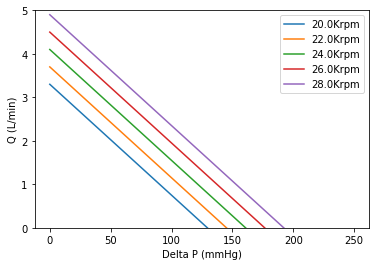

In [ ]:
#@title LVAD Pump Function
import numpy as np
from matplotlib import pylab as plt

# Input: H is in mmHg
# Output: Q is in L/min
def QLVAD(rpm, H):
  return (-0.0255*(H)+ rpm*0.2 - 0.7);

H = np.linspace(0,250)
Pspeed = np.linspace(20, 28, 5)
plt.figure()
for pspeed in Pspeed:
  Qlvad = QLVAD(pspeed, H)
  plt.plot(H, Qlvad,label=str(pspeed)+"Krpm")
plt.xlabel("Delta P (mmHg)")
plt.ylabel("Q (L/min)")
plt.ylim(0,5)
plt.legend()


In [ ]:
#@title Circulatory model
for i in np.arange(0,len(t)):

    Psa = 1/Csa*(Vsa - Vsa0);
    Psv = 1/Csv*(Vsv - Vsv0);
    Ppa = 1/Cpa*(Vpa - Vpa0);
    Ppv = 1/Cpv*(Vpv - Vpv0);
    
    # For calculating PLV
    f_LV = np.mod(ti,cycle_time);
    if (f_LV == 0):
        cycle_LV = ti/cycle_time;
        pumpmod = (LVAD_cyc_array >= cycle_LV).astype(int)
        pumpmod = np.argmax(pumpmod == 1)

    t_LV = ti-cycle_LV*cycle_time;
    PLV = e(t_LV,Tmax_LV,tau_LV)*Ees_LV*(VLV - V0_LV) + (1 - e(t_LV,Tmax_LV,tau_LV))*A_LV*(math.exp(B_LV*(VLV - V0_LV)) - 1);
    
    # For Calculating PRV
    f_RV = np.mod(ti,cycle_time);
    if (f_RV == 0): 
        cycle_RV = ti/cycle_time;

    t_RV = ti-cycle_RV*cycle_time;
    PRV = e(t_RV,Tmax_RV,tau_RV)*Ees_RV*(VRV - V0_RV) + (1 - e(t_RV,Tmax_RV,tau_RV))*A_RV*(math.exp(B_RV*(VRV - V0_RV)) - 1);
    
    # For Calculating Pla
    f_la = np.mod((ti+AV),cycle_time);
    if (f_la == 0):
        cycle_la = (ti+AV)/cycle_time + 1;

    if ti < 700:
        t_la = 0; 
    else:
        t_la = ti-(cycle_la-1)*cycle_time + AV;

    Pla = e(t_la,Tmax_la,tau_la)*Ees_la*(Vla - V0_la) + (1 - e(t_la,Tmax_la,tau_la))*A_la*(math.exp(B_la*(Vla - V0_la)) - 1);
    
    #For Calculation of Pra
    f_ra = np.mod((ti+AV),cycle_time);
    if f_ra == 0:
        cycle_ra = (ti+AV)/cycle_time + 1;

    if ti < 700:
        t_ra = 0; 
    else:
        t_ra = ti-(cycle_ra-1)*cycle_time + AV;

    Pra = e(t_ra,Tmax_ra,tau_ra)*Ees_ra*(Vra - V0_ra) + (1 - e(t_ra,Tmax_ra,tau_ra))*A_ra*(math.exp(B_ra*(Vra - V0_ra)) - 1);
    
    #conditions for Valves
    if(PLV <= Psa):    #Aortic valve
        Qav = 0;
    else:
        Qav = 1/Rav*(PLV - Psa);
    
    if(PLV >= Pla): #Mitral valve
        Qmv = 0;
    else:
        Qmv = 1/Rmv*(Pla - PLV);


    if(PRV <= Ppa):  #Pulmonary valve
        Qpvv = 0;
    else:
        Qpvv = 1/Rpvv*(PRV - Ppa);
 

    if(PRV >= Pra): #Tricuspid valve
        Qtv = 0;
    else:
        Qtv = 1/Rtv*(Pra - PRV);


    Qlvad = 0*QLVAD(LVAD_pumpspeed[pumpmod], (Psa - PLV)*0.0075)/60;

    Qsa = 1/Rsa*(Psa - Psv);
    Qsv = 1/Rsv*(Psv - Pra);
    Qpv = 1/Rpv*(Ppv - Pla);
    Qpa = 1/Rpa*(Ppa - Ppv);

    VLV = VLV + dt*(Qmv - Qav - Qlvad);
    Vsa = Vsa + dt*(Qav + Qlvad - Qsa);
    Vsv = Vsv + dt*(Qsa - Qsv);
    Vra = Vra + dt*(Qsv - Qtv);
    VRV = VRV + dt*(Qtv - Qpvv);
    Vpa = Vpa + dt*(Qpvv - Qpa);
    Vpv = Vpv + dt*(Qpa - Qpv);
    Vla = Vla + dt*(Qpv - Qmv);

    Vol[i,0] = VLV;
    Vol[i,1] = Vsa;
    Vol[i,2] = Vsv;
    Vol[i,3] = Vra;
    Vol[i,4] = VRV;
    Vol[i,5] = Vpa;
    Vol[i,6] = Vpv;
    Vol[i,7] = Vla;
    
    Prs[i,0] = PLV;
    Prs[i,1] = Psa;
    Prs[i,2] = Psv;
    Prs[i,3] = Pra;
    Prs[i,4] = PRV;
    Prs[i,5] = Ppa;
    Prs[i,6] = Ppv;
    Prs[i,7] = Pla;
    
    Q[i,0] = Qav;
    Q[i,1] = Qsa;
    Q[i,2] = Qsv;
    Q[i,3] = Qtv;
    Q[i,4] = Qpvv;
    Q[i,5] = Qpa;
    Q[i,6] = Qpv;
    Q[i,7] = Qmv;
    Q[i,8] = Qlvad;


    ti = ti + dt;


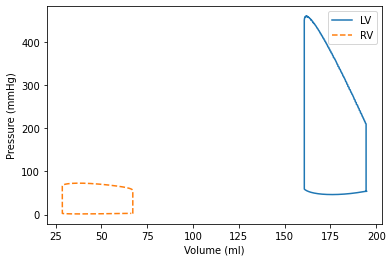

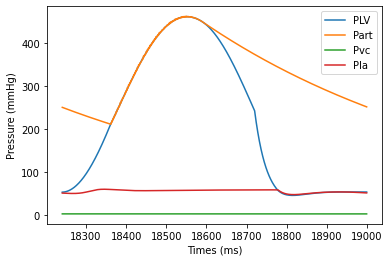

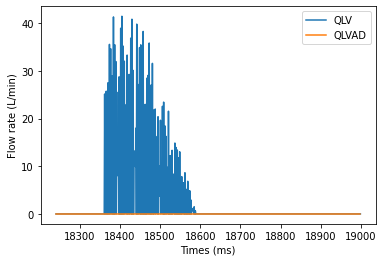

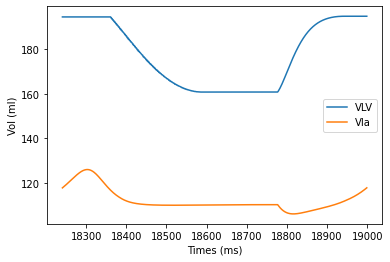

In [ ]:
#@title Plot PV loop
#ind = np.where(t>0)[0]
ind = np.where(t>(ncycle-1)*cycle_time)[0]
start_ind = ind[0]
end_ind = ind[len(ind)-1]
plt.figure(1)
plt.plot(Vol[start_ind:end_ind,0], Prs[start_ind:end_ind,0]*0.0075,'-',label="LV")
plt.plot(Vol[start_ind:end_ind,4], Prs[start_ind:end_ind,4]*0.0075,'--', label="RV")
plt.xlabel("Volume (ml)")
plt.ylabel("Pressure (mmHg)")
plt.legend()

plt.figure(2)
plt.plot(t[start_ind:end_ind], Prs[start_ind:end_ind,0]*0.0075, '-', label='PLV')
plt.plot(t[start_ind:end_ind], Prs[start_ind:end_ind,1]*0.0075, '-', label='Part')
plt.plot(t[start_ind:end_ind], Prs[start_ind:end_ind,2]*0.0075, '-', label='Pvc')
plt.plot(t[start_ind:end_ind], Prs[start_ind:end_ind,7]*0.0075, '-', label='Pla')
plt.xlabel("Times (ms)")
plt.ylabel("Pressure (mmHg)")
plt.legend()

plt.figure(3)
plt.plot(t[start_ind:end_ind], Q[start_ind:end_ind,0]*60, '-', label='QLV')
#plt.plot(t[start_ind:end_ind], Q[start_ind:end_ind,7]*60, '-', label='Qla')
plt.plot(t[start_ind:end_ind], Q[start_ind:end_ind,8]*60, '-', label='QLVAD')
plt.xlabel("Times (ms)")
plt.ylabel("Flow rate (L/min)")
plt.legend()

plt.figure(4)
plt.plot(t[start_ind:end_ind], Vol[start_ind:end_ind,0], '-', label='VLV')
plt.plot(t[start_ind:end_ind], Vol[start_ind:end_ind,7], '-', label='Vla')
plt.xlabel("Times (ms)")
plt.ylabel("Vol (ml)")
plt.legend()
